<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./312_fire_siberia_2019.ipynb"><< 312 - Siberian fires 2019 </a><span style="float:right;"><a href="./314_fire_chernobyl_2020_Sentinel-3_SLSTR_NRT_FRP_L2.ipynb">314 - Chernobyl fires 2020 - Sentinel-3 SLSTR NRT - FRP>></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES - FIRE</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** modules are prerequisites:
- [214 - Metop-A/B/C GOME-2 - Absorbing Aerosol Index - Level 3 - Load and browse](../20_data_discovery/214_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb)
- [231 - Metop-A/B IASI - NH<sub>3</sub> - Level 2 - Load and browse](../20_data_discovery/231_Metop-AB_IASI_NH3_L2_load_browse.ipynb)
- [241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2 - Load and browse](../20_data_discovery/241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb)
- [251 - Sentinel-3 OLCI - Radiances - Level 1 - Load and browse](../20_data_discovery/251_Sentinel-3_OLCI_radiance_L1_load_browse.ipynb)   
- [252 - Sentinel-3 SLSTR NRT - Fire Radiative Power - Level 2 - Load and browse](../20_data_discovery/252_Sentinel-3_SLSTR_NRT_FRP_L2_load_browse.ipynb)
- [253 - Sentinel-3 SLSTR NRT - Aerosol Optical Depth - Level 2 - Load and browse](../20_data_discovery/253_Sentinel-3_SLSTR_NRT_AOD_L2_load_browse.ipynb)

It is recommended to go through these modules before you start with this module.
</div>

<hr>

# 3.1.3 Discover Californian Fires 2020

During August and September 2020, wildfires raged for days along the US west coast. These fires were unprecedented in duration, extent and emissions. Read more about the extent of the Californian fires [here](https://scienceblog.eumetsat.int/2020/09/smoke-from-exceptional-california-wildfires-reach-europe/).

The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the following data products:

- [Sentinel-5P TROPOMI - Carbon Monoxide - Level 2](#sentinel_5p)
- [Sentinel-3 OLCI - False Color Composite - Level 1B](#sentinel3_olci)
- [Sentinel-3 SLSTR Near-Real-Time - Fire Radiative Power - Level 2](#s3_frp)
- [Sentinel-3 SLSTR Near-Real-Time - Aerosol Optical Depth - Level 2](#s3_aod)
- [Metop-A/B IASI - Total Column Carbon Monoxide - Level 2](#iasi_co)
- [Metop-A/B/C GOME-2 - Absorbing Aerosol Index - Level 3](#gome2_aai)


<hr>

#### Load required libraries

In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb
from skimage import exposure
import os

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.cm as cm

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [37]:
%run ../functions.ipynb

<hr>

## <a id='sentinel_5p'></a> Sentinel-5p Carbon Monoxide

#### Load the data with xarray's `open_mfdataset`

You can load all the datasets available for one day into one xarray object by using `scanline` as concatanation dimension.

In [88]:
s5p_mf = xr.open_mfdataset('../eodata/sentinel5p/co/2020/09/10/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 7907, time: 1)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 3.734e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2020-09-10
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 4.95e+04 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    longitude                              (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
Data variables:
    delta_time                             (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4172), meta=np.ndarray>
    time_utc                               (time, scanline) object dask.array<chunksize=(1, 4172), meta=np.ndarray>
    qa_value                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>

You are interested in the `carbonmonoxide_total_column` variable. You can extract the variable together with geographic coordinates and other information that might be helpful for visualising the data.

In [89]:
co = s5p_mf.carbonmonoxide_total_column[0,:,:]
lat = co.latitude
lon = co.longitude

latmin=10.
latmax=70.
lonmin=-150.
lonmax=-80.


The next step is to convert the data values from `mol per m2` to `molecules per cm2`. To do so, you have to multiply the data values with the conversion factor stored in the attribute `multiplication_factor_to_convert_to_molecules_percm2`.

In [90]:
co_converted = co* co.multiplication_factor_to_convert_to_molecules_percm2
co_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 7907, ground_pixel: 215)>
dask.array<mul, shape=(7907, 215), dtype=float32, chunksize=(4172, 215), chunktype=numpy.ndarray>
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 3.733e+03 3.734e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2020-09-10
    latitude      (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 215), meta=np.ndarray>
    longitude     (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 215), meta=np.ndarray>

#### Visualize the Carbon Monoxide Total Column with the function `visualize_pcolormesh`

The function [visualize_pcolormesh](../functions.ipynb#viusualize_pcolormesh) makes use of matplotlib's `pcolormesh` function to visualize the `Total Column Carbon Monoxide`.

In [ ]:
visualize_pcolormesh(data_array=co_converted*1e-18,
                     longitude=lon, 
                     latitude=lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='RdYlBu_r', 
                     unit='*1e-18 molecules per cm2', 
                     long_name=co.long_name, 
                     vmin=0, 
                     vmax=20, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column'}>)

<br>

## <a id='sentinel3_olci'></a>Sentinel-3 OLCI Level 1 False Color Composite

Sentinel-3 OLCI Level 1 False Color Composites can highlight areas of smoke resulting from wildfires. Let us go through each step required to load Sentinel-3 OLCI Level 1 data and to build a Red-Green-Blue False Color Composite.

#### Load OLCI channel information into one xarray object with xarray's function `xr.open_mfdataset`

You can load mulitple files at once with xarray's function `xr.open_mfdataset`. In the case of Sentinel-3 OLCI Level 1 data, you want to combine the data of all 21 channels into one xarray object. The structure of the single data files is equal, thus you can combine the data by coordinates by using the keyword argument `by_coords`.

In [11]:
olci_dir = '../eodata/sentinel3/olci/2020/09/07/S3B_OL_1_EFR____20200907T181635_20200907T181935_20200908T214254_0179_043_141_2340_LN1_O_NT_002.SEN3/'


In [12]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa10_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa11_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa12_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa13_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa14_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa15_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  12348
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2020-09-08T21:42:54Z
    history:                  2020-09-08T21:42:54Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3B_OL_1_EFR____20200907T181635_20200907T181935_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-09-07T18:16:35.055223Z
    stop_time:              2020-09-07T18:19:35.022927Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load the geo-coordinates and retrieve the data for `latitude` and `longitude`

You might want to georeference the resulting RGB image. Thus, you can already load the `geo_coordinates.nc` file and retrieve `latitude` and `longitude` information.

In [13]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<br>

#### Select the channels for the RGB composite

The function [select_channels_for_rgb](../functions.ipynb#rgb_channels) selects the chosen channels from the loaded xarray object. In this case, we select the channels `#17`, `#05` and `#02`. Those channels allow to build a false color composite that highlights healthy vegetation in red and also shows the fire smokes more prominently.

In [15]:
red, green, blue = select_channels_for_rgb(xarray=olci_xr_mf, 
                                           red_channel='Oa17_radiance', 
                                           green_channel='Oa05_radiance', 
                                           blue_channel='Oa02_radiance')


<br>

#### Normalize the channels `red`, `green` and `blue`

The function [normalize](../functions.ipynb#normalize) normalizes the data values within a range between 0 and 1.

In [16]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

<br>

#### Stack the RGB channels into a multi-dimensional array with `np.dstack`

In [17]:
rgb = np.dstack((redn, greenn, bluen))

<br>

#### Apply a histogram equalization 

A histogram equalization can improve the contrast of the resulting RGB composite. Thus, we use the `exposure` function from the ski-kit-learn library to equalize the image based on the data's histogram.

In [18]:
rgb = exposure.equalize_adapthist(rgb)

<br>

#### Map the RGB values onto a color array

If you want to visualize a georeferenced RGB image, you have to map the rgb values onto a color array with the following code:

In [20]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
#colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

<br>

#### Visualize the final RGB false color composite with the function `visualize_s3_pcolormesh`

Let's visualize the color array in a georeferenced way with matplotlib's function `pcolormesh`.

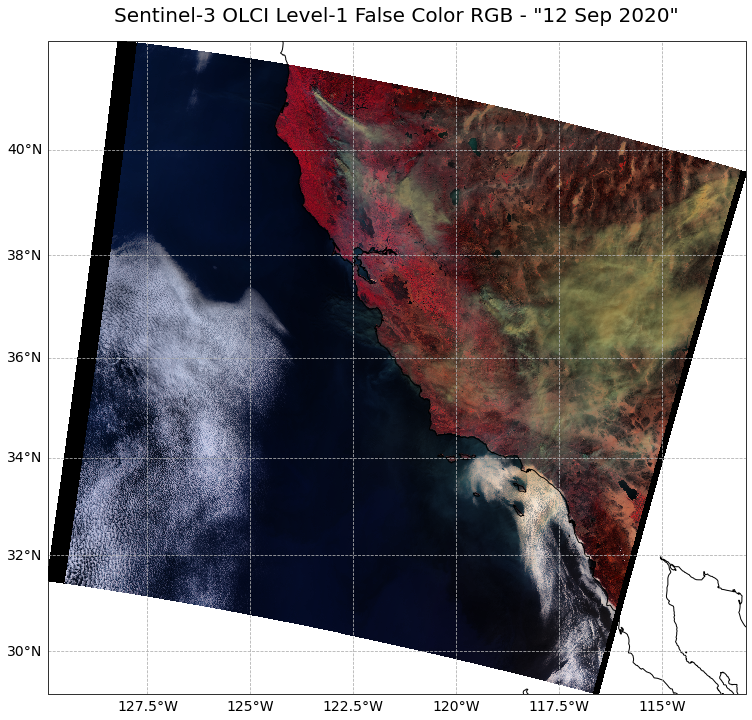

In [21]:
visualize_s3_pcolormesh(color_array=colorTuple, 
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 False Color RGB - "9 Sep 2020"')

<br>

## <a id='s3_frp'></a>Sentinel-3 Near-Real-Time SLSTR Fire Radiative Power

#### Load `S3 NRT SLSTR FRP` data with xarray's `xr.open_dataset` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic Anomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [41]:
frp_dir = '../eodata/sentinel3/slstr/2020/09/12/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_California_202000912.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 983, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200912T060733_20200912T061233_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-09-12T08:42:25Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  23806
    start_time:             2020-09-12T06:07:32.889933Z
    stop_time:              2020-09-12T06:12:32.876462Z
    track_offset:           998
    start_offset:           2960

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [42]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lat_frp

<xarray.DataArray 'latitude' (fires: 983)>
array([34.20978 , 34.207463, 34.206402, ..., 44.773218, 44.780361, 44.815262])
Dimensions without coordinates: fires
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [43]:
sampling_lat_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 30.        # Minimum latitude for mapping plot [deg N]
lat_max               = 50.        # Maximum latitude for mapping plot [deg N]
lon_min               = -125.        # Minimum lonitude for mapping plot [deg E]
lon_max               = -110.        # Maximum lonitude for mapping plot [deg E]

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

#### <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variable contains a total of 983 fire entries.

In [44]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 983)>
array([29.001723,  3.319766,  6.212274, ...,  3.228371,  2.052163,  2.190705])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

The next step is to extract (mask) only the valid. Valid pixels are different to -1. You can use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to extract the right pixels.

There are 947 fire entries from the `MWIR` channel. These fires have a temperature less than 1000 Kelvin.

In [31]:
masked_frp_mwir = generate_masked_array(xarray=frp_mwir, 
                                        mask=frp_mwir, 
                                        threshold=-1.,
                                        operator='!=', 
                                        drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 947)>
array([2.90017228e+01, 3.31976591e+00, 6.21227395e+00, 1.54620940e+01,
       4.68897270e+01, 1.12332114e+00, 6.18965174e+01, 6.19149670e+01,
       1.49150777e+01, 2.68553413e+01, 1.10069436e+02, 2.45775621e+01,
       2.61668130e+01, 4.33408987e+01, 1.64290944e+01, 1.83668273e+01,
       2.62899536e+01, 2.05406704e+01, 2.11985483e+01, 1.39026835e+01,
       9.83339434e+00, 8.96743356e-01, 3.24738038e+01, 8.82385523e+00,
       9.79953234e+00, 1.01516512e+01, 1.06332844e+01, 7.59713837e+00,
       4.82291892e+00, 4.24031284e+01, 1.59761809e+01, 8.05953998e+00,
       2.95407260e+01, 2.31222189e+01, 3.27043456e+01, 1.68782050e+01,
       8.78751404e+01, 8.78545978e+01, 1.13304826e+01, 2.08873465e+01,
       3.07980512e+01, 2.59300387e+01, 1.03644351e+01, 1.86258119e+01,
       1.27626475e+01, 2.50509373e+01, 4.19246990e+01, 7.57480551e+00,
       4.18505043e+00, 5.81507143e+01, 1.14371338e+01, 2.03450912e+01,
       3.70746321e+01, 1.78408309e+01, 1.60965106e+01, 8.59292190e+00,
       1.22158347e+01, 1.03185624e+01, 9.17456144e+00, 9.27152823e+00,
       3.49734224e+01, 3.49308318e+01, 5.29665226e+00, 1.66800539e+01,
       1.01586137e+01, 8.22362855e+00, 3.16841166e+01, 6.83258678e+00,
       8.42721879e+00, 1.61962517e+01, 8.20943020e+00, 2.28961160e+01,
       2.52468381e+01, 1.52548126e+01, 5.38491262e+00, 2.42656409e+01,
       3.16232026e+01, 4.84855103e+00, 7.31684297e+01, 5.22320158e+00,
...
       1.78856947e+00, 2.41569105e+00, 2.81981323e+00, 1.73451445e+00,
       1.18740627e+00, 1.80706389e+01, 2.86287477e+00, 2.69165373e+00,
       1.29910697e+01, 1.56731741e+01, 3.69249921e+00, 4.31241887e+00,
       1.98103432e+00, 2.12256215e+00, 2.32410247e+00, 2.19475492e+01,
       3.61717005e+00, 3.61494431e+00, 3.19642464e+00, 3.61449539e+00,
       4.91066825e+00, 1.03807410e+01, 2.10834044e+00, 2.09997201e+01,
       3.49179818e+00, 4.17740751e+00, 4.16992738e+00, 2.33489186e+00,
       3.55750619e+00, 6.87252687e+00, 2.97174139e+00, 2.79907336e+00,
       4.19815756e+00, 5.93116206e+00, 4.76309675e+00, 4.10701547e+00,
       4.59747954e+00, 3.26218998e+00, 6.89366635e+00, 8.99779051e+00,
       7.42398859e+00, 1.95245927e+01, 6.84967037e+00, 1.81849789e+00,
       1.31833361e+00, 4.45365592e+00, 3.52931715e+00, 1.25635260e+00,
       4.04953166e+00, 1.98248985e+00, 1.98208059e+00, 1.02024401e+00,
       1.52514242e+00, 1.61625397e+00, 2.86512589e+00, 8.94506595e-01,
       1.18528220e+00, 1.02283092e+00, 2.95828143e+00, 4.66141381e+00,
       2.31194599e+00, 3.43929993e+00, 2.37473881e+00, 8.95867030e-01,
       8.85686092e-01, 1.09169750e+00, 3.18484807e+00, 8.87985420e-01,
       1.56605980e+00, 1.22353878e+00, 1.16370672e+00, 1.15645119e+00,
       8.84748225e-01, 1.15574361e+00, 1.16390325e+00, 1.22427473e+00,
       3.22837072e+00, 2.05216264e+00, 2.19070534e+00])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

Let us store the number of of hotspots / fires in total and per category as variables.

In [45]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(983, 947)

#### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can use the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to do it.

Apply the function `slstr_frp_gridding` to the `frp_mwir` data array.

In [46]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir,
                                                       parameter='mwir',
                                                       lat_min=lat_min, 
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.025, 30.025, 30.025, ..., 30.025, 30.025, 30.025],
        [30.075, 30.075, 30.075, ..., 30.075, 30.075, 30.075],
        [30.125, 30.125, 30.125, ..., 30.125, 30.125, 30.125],
        ...,
        [49.925, 49.925, 49.925, ..., 49.925, 49.925, 49.925],
        [49.975, 49.975, 49.975, ..., 49.975, 49.975, 49.975],
        [50.025, 50.025, 50.025, ..., 50.025, 50.025, 50.025]],
       dtype=float32),
 array([[-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -

<br>

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for the masking.

In [34]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Calculate some statistics, e.g. mean, std, min and max, and add them to a string that can be integrated in the final plot.

In [35]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



#### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can make use of the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp), which uses matplotlib's `pcolormesh` function to visualize a numpy array.

The function takes the following keyword arguments:
* `data`: DataArray with fire hotspots
* `lat`: Latitude information
* `lon`: Longitude information
* `unit`: Unit of the data values
* `longname`: Long name of the data
* `textstr_1`: Text that contains the total number of 1km hot-spots
* `textstr_2`: Text that contains summary statistics of the data
* `vmax`: Maximum value to be visualized

Now, you can apply the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

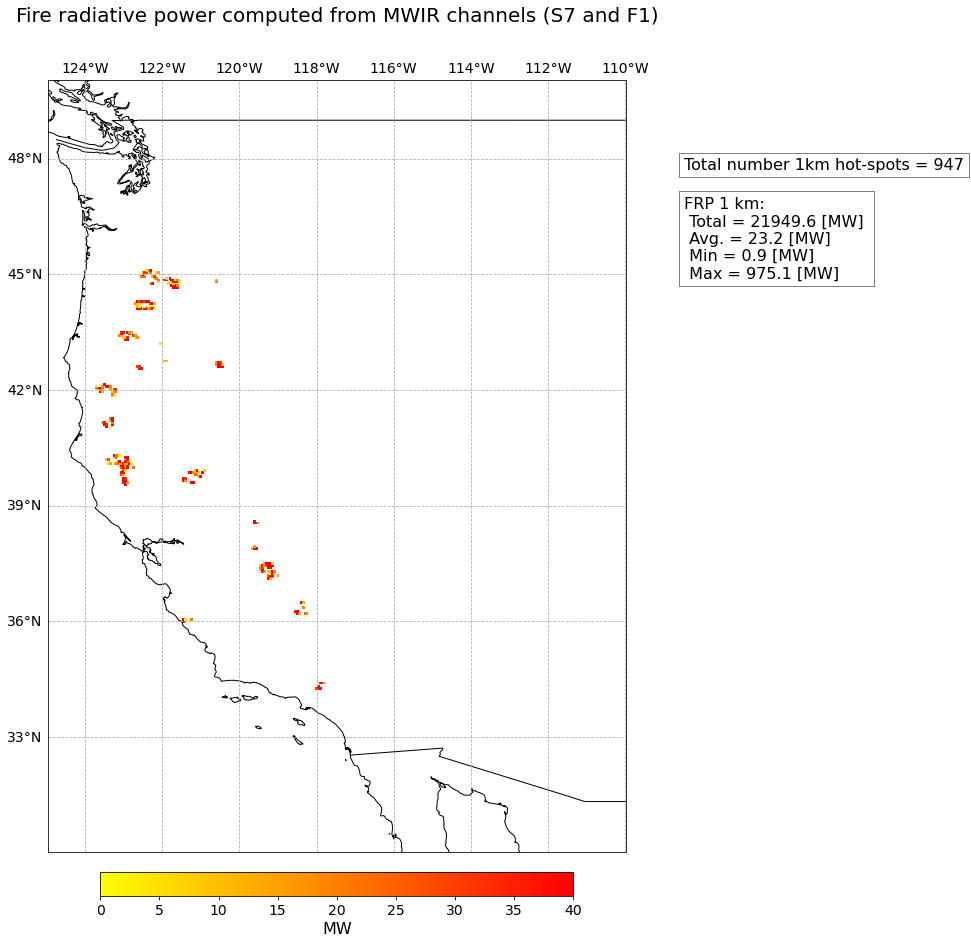

In [39]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

## <a id='s3_aod'></a>Sentinel-3 Near-Real-Time SLSTR Aerosol Optical Depth

#### <a id='load'></a>Load Sentinel-3 SLSTR AOD data

The Sentinel-3 Near-Real-Time SLSTR Aerosol Optical Depth data are disseminated in `netCDF`. `netCDF` data can be loaded with the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `xr.open_dataset()`. 

You see that the data file contains two `dimensions`:
* `columns` and
* `rows`.

It further contains an long list of `data variables`, including:
* `AOD_550`,
* `AOD_550_uncertainty`,
* `AOD_550_Ocean_NonFiltered`,
* `AOD_550_Land_Experimental_PostFiltered`,
...

A data file also contains a set of `attributes`, which give you more information about the data file and the data it contains, e.g the `start_time` and `stop_time` or the `product_name`.

In [49]:
file = xr.open_dataset('../eodata/sentinel3/slstr/2020/10/01/AOD_California_20201001.nc')
file

<xarray.Dataset>
Dimensions:                                                (columns: 157, rows: 210)
Dimensions without coordinates: columns, rows
Data variables:
    AOD_550                                                (rows, columns) float32 ...
    AOD_550_uncertainty                                    (rows, columns) float32 ...
    AOD_670                                                (rows, columns) float32 ...
    AOD_865                                                (rows, columns) float32 ...
    AOD_1600                                               (rows, columns) float32 ...
    AOD_2250                                               (rows, columns) float32 ...
    FM_AOD550                                              (rows, columns) float32 ...
    AFRI                                                   (rows, columns) float32 ...
    Smoke_Index                                            (rows, columns) float32 ...
    ANG550_865                                             (rows, columns) float32 ...
    D_AOD550                                               (rows, columns) float32 ...
    AAOD550                                                (rows, columns) float32 ...
    SSA_550                                                (rows, columns) float32 ...
    Surface_reflectance_550                                (rows, columns) float32 ...
    SSA_670                                                (rows, columns) float32 ...
    SSA_865                                                (rows, columns) float32 ...
    SSA_1600                                               (rows, columns) float32 ...
    SSA_2250                                               (rows, columns) float32 ...
    AOD_550_Ocean_NonFiltered                              (rows, columns) float32 ...
    AOD_550_uncertainty_Ocean_NonFiltered                  (rows, columns) float32 ...
    AOD_550_Land_Experimental_NonFiltered                  (rows, columns) float32 ...
    AOD_550_Land_Experimental_PostFiltered                 (rows, columns) float32 ...
    AOD_550_uncertainty_Land_Experimental_NonFiltered      (rows, columns) float32 ...
    FM_AOD550_Land_Experimental_NonFiltered                (rows, columns) float32 ...
    Surface_reflectance_550_Land_Experimental_NonFiltered  (rows, columns) float32 ...
    time_reference_a                                       (rows) datetime64[ns] ...
    time                                                   (rows, columns) timedelta64[ns] ...
    latitude                                               (rows, columns) float32 ...
    longitude                                              (rows, columns) float32 ...
    pixel_corner_latitude_Corner_1                         (rows, columns) float32 ...
    pixel_corner_longitude_Corner_1                        (rows, columns) float32 ...
    pixel_corner_latitude_Corner_2                         (rows, columns) float32 ...
    pixel_corner_longitude_Corner_2                        (rows, columns) float32 ...
    pixel_corner_latitude_Corner_3                         (rows, columns) float32 ...
    pixel_corner_longitude_Corner_3                        (rows, columns) float32 ...
    pixel_corner_latitude_Corner_4                         (rows, columns) float32 ...
    pixel_corner_longitude_Corner_4                        (rows, columns) float32 ...
    sun_zenith_nadir                                       (rows, columns) float32 ...
    sun_zenith_oblique                                     (rows, columns) float32 ...
    satellite_zenith_nadir                                 (rows, columns) float32 ...
    satellite_zenith_oblique                               (rows, columns) float32 ...
    relative_azimuth_nadir                                 (rows, columns) float32 ...
    relative_azimuth_oblique                               (rows, columns) float32 ...
    cloud_fraction_nadir                                   (rows, columns) float32 ...
  

#### <a id='extract'></a>Extract Aerosol Optical Depth variables

The next step is to extract the variables of interest. Let us select the following two variables:
* `AOD_550`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers ocean surfaces.*)
* `AOD_550_Land_Experimental_PostFiltered`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers land surfaces.*)

Both `DataArrays` have two dimensions (`rows` and `columns`) and the following attributes, which provide additional information about the variables:
* `long_name`
* `standard_name`
* `valid_min`
* `valid_max`
* `coordinates`

In [50]:
aod_ocean = file.AOD_550
aod_land = file.AOD_550_Land_Experimental_PostFiltered
print(aod_ocean)
print(' ')
print(aod_land)

<xarray.DataArray 'AOD_550' (rows: 210, columns: 157)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Aerosol optical thickness at 550 nm - Best quality (post-...
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol
    valid_min:      0.0
    valid_max:      4.001
    coordinates:    latitude, longitude
 
<xarray.DataArray 'AOD_550_Land_Experimental_PostFiltered' (rows: 210, columns: 157)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan,

You can also load `latitude` and `longitude` information, which can be used later for visualizing the variables.

In [51]:
lat_nc = file.latitude
lon_nc = file.longitude
print(lat_nc)
print(' ')
print(lon_nc)

<xarray.DataArray 'latitude' (rows: 210, columns: 157)>
array([[40.54374 , 40.533485, 40.523174, ..., 37.763252, 37.73665 , 37.71009 ],
       [40.46065 , 40.45038 , 40.44005 , ..., 37.676662, 37.649994, 37.62782 ],
       [40.377556, 40.367268, 40.35692 , ..., 37.593685, 37.571865, 37.54554 ],
       ...,
       [23.316261, 23.302357, 23.288424, ..., 20.575003, 20.553972, 20.533533],
       [23.232931, 23.21901 , 23.205057, ..., 20.492165, 20.4701  , 20.45003 ],
       [23.1496  , 23.13566 , 23.121693, ..., 20.407766, 20.387156, 20.366516]],
      dtype=float32)
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Latitude at pixel centre
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0
 
<xarray.DataArray 'longitude' (rows: 210, columns: 157)>
array([[-132.85818 , -132.74686 , -132.63556 , ..., -116.28708 , -116.182686,
        -116.08103 ],
       [-132.87125 , -132.76007 , -132.6489  , ..., -1

#### <a id='visualize'></a> Visualize AOD Ocean and AOD Land variables

The final step is to visualize both variables, Aerosol Optical Depth over ocean and land together in one plot. You can use the function [visualize_s3_aod](../functions.ipynb#visualize_s3_aod) to do so.

The function takes the following keyword arguments (kwargs):
* `aod_ocean`: DataArray with AOD values over ocean
* `aod_land`: DataArray with AOD values over land
* `latitude`: DataArray with latitude information
* `longitude`: DataArray with longitude information
* `title`: Title of the plot
* `unit`: Unit of AOD
* `vmin` and `vmax`: Minimum and maximum values to be displayed on the map
* `color_scale`: Color scale the data shall be represented
* `projection`: Projection of the map

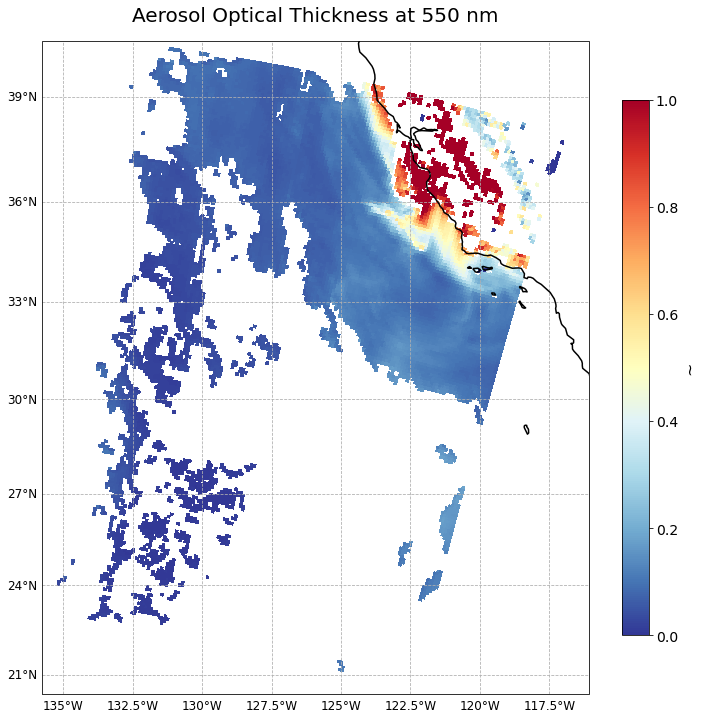

In [52]:
visualize_s3_aod(aod_ocean=aod_ocean, 
                 aod_land=aod_land, 
                 latitude=lat_nc, 
                 longitude=lon_nc, 
                 title='Aerosol Optical Thickness at 550 nm', 
                 unit='~', 
                 vmin=0.,
                 vmax=1.0,
                 color_scale='RdYlBu_r',
                 projection=ccrs.Mercator())

<br>

## <a id='iasi_co'></a>Metop-B IASI - Total Column Carbon Monoxide - Level 2

#### Load netCDF data with `xarray`

IASI Level 2 data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `netCDF` format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/index.html) to access and manipulate datasets in `netCDF` format.

Xarray's function `xr.open_dataset` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure.

You see, that the data is a 3-dimensional vector with more than 540,000 individual entries for the `time` dimension. `latitude`, `longitude` and other parameters are stored as individual data variables.

In [68]:
iasi_file = xr.open_dataset('../eodata/iasi/nc/2b/2020/09/11/IASI_METOPB_L2_CO_20200911_ULB-LATMOS_V6.5.0.nc')

iasi_file

<xarray.Dataset>
Dimensions:                            (nlayers: 19, npressures: 20, time: 542455)
Coordinates:
  * time                               (time) float64 4.322e+08 ... 4.323e+08
Dimensions without coordinates: nlayers, npressures
Data variables:
    time_string                        (time) |S16 ...
    time_in_day                        (time) float64 ...
    latitude                           (time) float32 ...
    longitude                          (time) float32 ...
    solar_zenith_angle                 (time) float32 ...
    satellite_zenith_angle             (time) float32 ...
    orbit_number                       (time) int64 ...
    scanline_number                    (time) int32 ...
    pixel_number                       (time) int32 ...
    ifov_number                        (time) int32 ...
    retrieval_quality_flag             (time) int32 ...
    surface_altitude                   (time) float32 ...
    CO_apriori_partial_column_profile  (time, nlayers) float32 ...
    CO_partial_column_profile          (time, nlayers) float32 ...
    CO_partial_column_error            (time, nlayers) float32 ...
    CO_total_column                    (time) float32 ...
    CO_total_column_error              (time) float32 ...
    CO_degrees_of_freedom              (time) float32 ...
    air_partial_column_profile         (time, nlayers) float32 ...
    atmosphere_pressure_grid           (time, npressures) float32 ...
    averaging_kernel_matrix            (time, nlayers, nlayers) float32 ...
Attributes:
    title:                       IASI/METOPB ULB-LATMOS carbon monoxide (CO) ...
    institution:                 ULB-LATMOS for algorithm development ; EUMET...
    product_version:             6.5.0
    history:                     2020-09-12 06:32:03 (date of data extraction...
    summary:                     This dataset contains Level 2 carbon monoxid...
    source:                      EUMETSAT IASI Level 2 carbon monoxide (CO) d...
    references:                  Reference to the CO retrieval: FORLI radiati...
    id:                          IASI_METOPB_L2_CO_20200911_ULB-LATMOS_V6.5.0.nc
    tracking_id:                 e7d9ad0e-f4b0-11ea-acff-73d7f7916c85
    geospatial_lat_min:          -90.0
    geospatial_lat_max:          +90.0
    geospatial_latitude_units:   degrees_north
    geospatial_lon_min:          -180.0
    geospatial_lon_max:          +180.0
    geospatial_longitude_units:  degrees_east
    geospatial_vertical_min:     0
    geospatial_vertical_max:     60
    geospatial_vertical_units:   km
    time_coverage_start:         20191201T000000Z
    time_coverage_end:           20191201T235959Z
    conventions:                 CF-1.6
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Medata Conv...
    keywords:                    satellite,observation,atmosphere,carbon mono...
    keywords_vocabulary:         GCMD Science Keywords
    platform:                    Metop-B
    sensor:                      IASI
    spatial_resolution:          12km at nadir
    creator_type:                institution
    creator_name:                ULB-LATMOS
    contact_email:               contact form at http://iasi.aeris-data.fr/co...
    data_policy:                 see https://iasi.aeris-data.fr/data-use-policy/

As a next step, you can select the variable `CO_total_column`, which holds data values for total column carbon monoxide.

In [69]:
co = iasi_file['CO_total_column']
co

<xarray.DataArray 'CO_total_column' (time: 542455)>
[542455 values with dtype=float32]
Coordinates:
  * time     (time) float64 4.322e+08 4.322e+08 ... 4.323e+08 4.323e+08
Attributes:
    units:                                                  mol m-2
    long_name:                                              retrieved carbon ...
    standard_name:                                          atmosphere_mole_c...
    ancillary_variables:                                    CO_total_column_e...
    multiplication_factor_to_convert_to_molecules_per_cm2:  6.02214086e+19

#### Load data into a xarray.DataArray with the function `generate_xr_from_1D_vec`

With the help of the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec), you can generate a `xarray.DataArray` object, with `latitude` and `longitude` values as coordinates and the total column carbon monoxide information as data values. This data structure will be helpful for plotting and masking the data.

Further, you can retrieve the information for the variables `long_name`, `unit` and `variable name` from the attributes of the data object `co`.

In [71]:
iasi_co_da = generate_xr_from_1D_vec(file=iasi_file,
                                     lat_path='latitude', 
                                     lon_path='longitude',
                                     variable=co, 
                                     parameter_name=co.name, 
                                     longname=co.long_name, 
                                     no_of_dims=1, 
                                     unit=co.units)

iasi_co_da

<xarray.DataArray 'CO_total_column' (ground_pixel: 542455)>
array([0.03949106, 0.03213775, 0.04679925, ..., 0.03180185, 0.03522488,
       0.03115139], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 8.665 8.915 8.798 ... 84.91 84.73 85.22
    longitude  (ground_pixel) float32 -47.95 -48.01 -48.49 ... -66.97 -54.55
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

#### Load quality flag information

The IASI Level 2 data files provide you information on the quality for each data point. This information is useful to generate a quality mask and to mask out data points with a non sufficient quality.

In order to do so, you have to load the quality flag variable `retrieval_quality_flag` from the data file. The pixels with a `quality flag = 2` are the most reliable pixels. Pixels with a `quality flag = 1 or 0` shall be masked out.

In [72]:
qf = iasi_file['retrieval_quality_flag']
qf

<xarray.DataArray 'retrieval_quality_flag' (time: 542455)>
[542455 values with dtype=int32]
Coordinates:
  * time     (time) float64 4.322e+08 4.322e+08 ... 4.323e+08 4.323e+08
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    comment:    = 2 for the most reliable pixels; = 1 for the valuable pixels...

You can re-use the [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) function again in order to generate a `xarray.DataArray` with the quality flag information.

In [73]:
iasi_co_qf_da = generate_xr_from_1D_vec(file=iasi_file,
                                        lat_path='latitude', 
                                        lon_path='longitude', 
                                        variable=qf, 
                                        parameter_name=qf.name, 
                                        longname=qf.long_name, 
                                        no_of_dims=1, 
                                        unit='-')
iasi_co_qf_da

<xarray.DataArray 'retrieval_quality_flag' (ground_pixel: 542455)>
array([1, 1, 1, ..., 2, 2, 2], dtype=int32)
Coordinates:
    latitude   (ground_pixel) float32 8.665 8.915 8.798 ... 84.91 84.73 85.22
    longitude  (ground_pixel) float32 -47.95 -48.01 -48.49 ... -66.97 -54.55
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    units:      -

#### Mask the Total Column Carbon Monoxide data

The quality flag information can now be used to mask the `xarray.DataArray` with the data values. You can make use of the function [generate_masked_array](../functions.ipynb#generate_masked_array), where you can specify which pixels shall remain and which ones shall be eliminated. All data points with a `quality flag = 2` shall be kept, all others shall be masked out.

You see that the number of data points reduced to just a bit less than 400,000 instead of more than 500,000.

In [74]:
iasi_co_masked = generate_masked_array(xarray=iasi_co_da,
                                       mask=iasi_co_qf_da,
                                       threshold=2,
                                       operator='=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 392634)>
array([0.02875579, 0.0296423 , 0.03025403, ..., 0.03180185, 0.03522488,
       0.03115139], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 9.989 10.37 10.54 ... 84.91 84.73 85.22
    longitude  (ground_pixel) float32 -43.75 -41.56 -41.6 ... -66.97 -54.55
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

#### Convert the Total Column Carbon Monoxide data from mol/m<sup>2</sup> to molecules/cm<sup>2</sup>

The last step before visualizing the total column carbon monoxide information is to convert the data from `mol/m2` to `molecules/cm2`. The loaded data variable `co` has an attribute called `multiplication_factor_to_convert_to_molecules_per_cm2`, which is used to convert the data values.

In [75]:
iasi_co_masked_converted = iasi_co_masked*co.multiplication_factor_to_convert_to_molecules_per_cm2
iasi_co_masked_converted 

<xarray.DataArray (ground_pixel: 392634)>
array([1.7317139e+18, 1.7851012e+18, 1.8219404e+18, ..., 1.9151522e+18,
       2.1212919e+18, 1.8759807e+18], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 9.989 10.37 10.54 ... 84.91 84.73 85.22
    longitude  (ground_pixel) float32 -43.75 -41.56 -41.6 ... -66.97 -54.55
Dimensions without coordinates: ground_pixel

#### Visualize the masked dataset with the function `visualize_scatter`

You can visualize the IASI Total Column Carbon Monoxide data with the function [visualize_scatter](../functions.ipynb#visualize_scatter), which uses matplotlib's `scatterplot` function. You can set an `Orthographic()` projection and focus on a region over California.

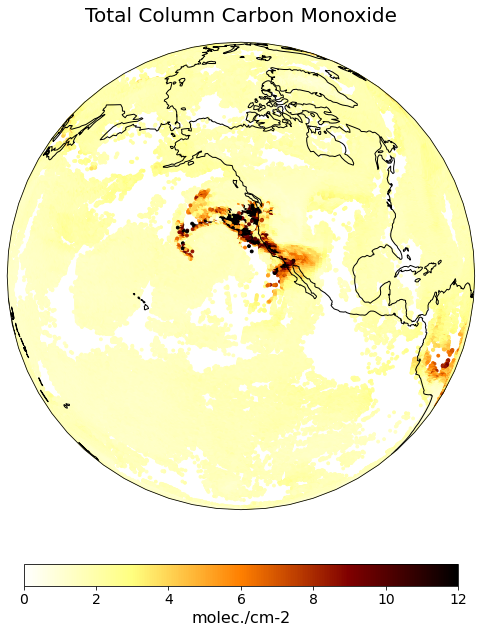

In [78]:
visualize_scatter(xr_dataarray=iasi_co_masked_converted, 
                  conversion_factor=1e-18,
                  projection=ccrs.Orthographic(-130,30), 
                  vmin=0, 
                  vmax=12, 
                  point_size=8, 
                  color_scale='afmhot_r', 
                  unit='molec./cm-2', 
                  title='Total Column Carbon Monoxide')

<br>

## <a id='gome2_aai'></a>Metop-A/B/C GOME-2 Absorbing Aerosol Index (AAI) Level 3

#### Load a time-series of daily GOME-2 Level 3 AAI data into one a `xarray.Dataset` object

The function `xr.open_mfdataset()` from the xarray library allows the openening of multiple NetCDF files at once. You have to specify the dimension the files shall be concatenated on. It can be an existing dimension of the data file or a new dimension, which is newly specified.

Let us open the daily gridded AAI data from Metop-A for 11 days from 5 to 15 September 2020 and we specify `time` as a new dimension the data files shall be concatenated on.

After you loaded the multiple files in a `xarray.Dataset` with the function `open_mfdataset()`, you have to select again `absorbing_aerosol_index` as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).

In [79]:
ds_a = xr.open_mfdataset('../eodata/gome2/level3/aai/2020_californian_fires/ESACCI-AEROSOL-L3-AAI-GOME2A*.nc', concat_dim='time', combine='nested')
aai_a=ds_a['absorbing_aerosol_index']
aai_a

<xarray.DataArray 'absorbing_aerosol_index' (time: 11, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(11, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

The same process has to be repeated for the daily gridded AAI data from the satellites Metop-B and Metop-C respectively.
Below, we load the data from the Metop-B satellite.

In [80]:
ds_b = xr.open_mfdataset('../eodata/gome2/level3/aai/2020_californian_fires/ESACCI-AEROSOL-L3-AAI-GOME2B*.nc', concat_dim='time', combine='nested')
aai_b=ds_b['absorbing_aerosol_index']
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 11, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(11, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

And here, we load the daily gridded AAI data files from the Metop-C satellite.

In [81]:
ds_c = xr.open_mfdataset('../eodata/gome2/level3/aai/2020_californian_fires/ESACCI-AEROSOL-L3-AAI-GOME2C*.nc', concat_dim='time', combine='nested')
aai_c=ds_c['absorbing_aerosol_index']
aai_c

<xarray.DataArray 'absorbing_aerosol_index' (time: 11, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(11, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

#### Concatenate the data from the three satellites Metop-A, -B and -C

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A, -B and -C and we call the dimension `satellite`. 
You can use the `concat()` function from the xarray library.

The result is a four-dimensional `DataArray`, with the dimensions `satellite`, `time`, `latitude` and `longitude`.

You can see that the resulting `DataArray` holds coordinate information for the two spatial dimensions `longitude` and `latitude`, but not for `time` and `satellite`.

However, especially the coordinates for `time` will be important for plotting, to know for which day the data is valid. Thus, a next step is to assign coordinates to the `time` dimension.

In [82]:
aai_concat = xr.concat([aai_a,aai_b,aai_c], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 11, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(3, 11, 180, 360), dtype=float32, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite, time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

#### Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the metadata of a single data file, you can see that the only metadata attribute that contains the valid time step is the `description` attribute.

The first step is to retrieve the metadata attribute `description` and split the resulting string object at the positions with a space. The day string is the fourth position of the resulting string.

The `description` attribute can be accessed directly from the `xr_single_file` object.

In [83]:
xr_single_file = xr.open_dataset('../eodata/gome2/level3/aai/2020_californian_fires/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200905-fv1.8.nc')
start_day = xr_single_file.description.split()[4]
start_day

'05-09-2020'

With the help of the Python library `pandas`, you can build a `DateTime` time series for 24 consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `aai_concat` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DateTime` information from 5 to 15 September 2020.

In [84]:
time_coords = pd.date_range(datetime.strptime(start_day, '%d-%m-%Y'),periods=len(aai_concat.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14', '2020-09-15'],
              dtype='datetime64[ns]', freq=None)

The final step is to assign the pandas time series object `time_coords` to the `aai_concat` DataArray object. You can use the `assign_coords()` function from the xarray library.

The result is that only the `satellite` dimension does not have any coordinates defined.

In [85]:
aai_concat = aai_concat.assign_coords(time=time_coords)
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 11, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(3, 11, 180, 360), dtype=float32, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2020-09-05 2020-09-06 ... 2020-09-15
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

#### Combine AAI data from the three satellites Metop-A, -B, and -C onto one single grid

Since the final aim is to combine the data from the three satellites Metop-A, -B and -C onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reducer function `mean` to the `aai_concat` Data Array. The dimension (`dim`) to be reduced shall be the `satellite` dimension.

This function builds the average of all data points within a grid cell. The resulting `xarray.DataArray` has three dimensions `time`, `latitude` and `longitude`.

In [86]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (time: 11, latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(11, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2020-09-05 2020-09-06 ... 2020-09-15

#### Visualize AAI data with data from the three satellites Metop-A, -B, and C combined on one single grid

The final step is to visualize the the Aerosol Absorbing Index data for one time step. You can use the function `visualize_pcolormesh` for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, and you can add the valid time step to the title of the plot.

The resulting plot shows elevated AAI levels on the US west coast on 15 September 2020.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Absorbing aerosol index averaged for each grid cell 2020-09-15'}>)

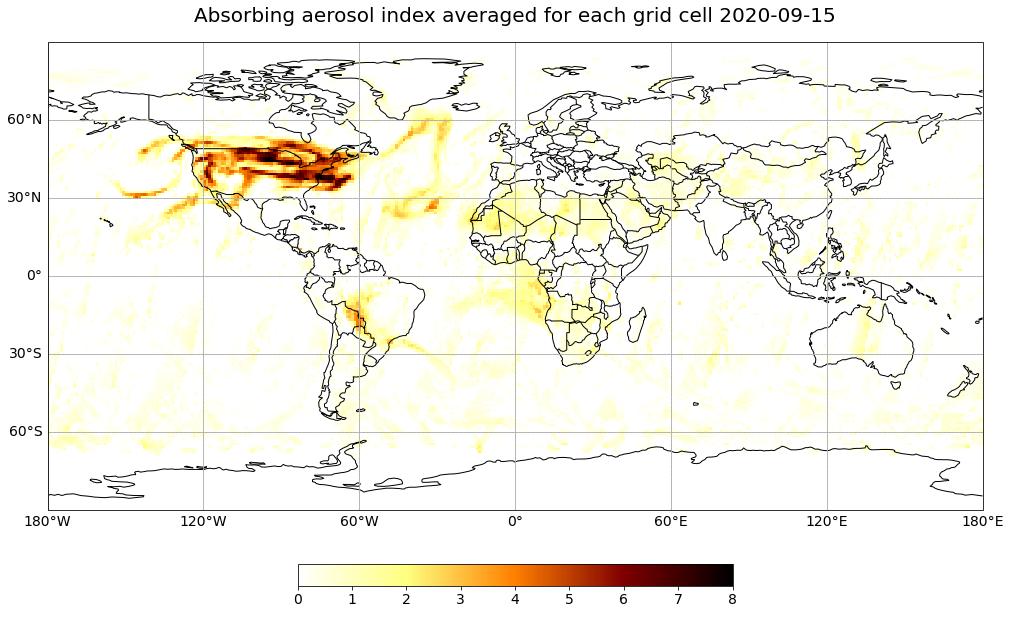

In [87]:
visualize_pcolormesh(data_array=aai_combined[10,:,:],
                     longitude=aai_combined.longitude, 
                     latitude=aai_combined.latitude,
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=' ',
                     long_name=aai_a.long_name + ' ' + str(aai_combined.time[10].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=8)


<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./312_fire_siberia_2019.ipynb"><< 312 - Siberian fires 2019 </a><span style="float:right;"><a href="./314_fire_chernobyl_2020_Sentinel-3_SLSTR_NRT_FRP_L2.ipynb">314 - Chernobyl fires 2020 - Sentinel-3 SLSTR NRT - FRP>></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>